In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

from green_mood_tracker.training_data import get_raw_data_notebook
from green_mood_tracker.data_cleaning import clean

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cleme\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## download data

In [2]:
%%time
raw_data = get_raw_data_notebook()
raw_data.head()

c:\users\cleme\.venvs\lewagon\lib\site-packages\green_mood_tracker\training_data.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sentiment140_final['source'] = 'sentiment140'


Wall time: 6.7 s


,id,text,polarity,source
0,1467933112,the angel is going to miss the athlete this we...,0,sts_gold
1,2323395086,It looks as though Shaq is getting traded to C...,0,sts_gold
2,1467968979,@clarianne APRIL 9TH ISN'T COMING SOON ENOUGH,0,sts_gold
3,1990283756,drinking a McDonalds coffee and not understand...,0,sts_gold
4,1988884918,So dissapointed Taylor Swift doesnt have a Twi...,0,sts_gold


In [3]:
raw_data.shape

(1633048, 4)

## Explore data

In [4]:
raw_data.source.value_counts()

sentiment140              1600000
kaggle_sentiment_train      27480
kaggle_sentiment_test        3534
sts_gold                     2034
Name: source, dtype: int64

In [5]:
raw_data.polarity.value_counts()

2    810317
0    810184
1     12547
Name: polarity, dtype: int64

## sample data

In [6]:
data_sample = raw_data.sample(n=25_000,random_state=0).reset_index()

In [7]:
%%time
data_sample_clean = clean(data_sample,'text')
data_sample_clean.head()

Wall time: 3.8 s


,index,id,text,polarity,source
0,89497,1755343696,headed yonkers back later tonight,0,sentiment140
1,212595,1974776713,tried callin past dayz tu e bueno wey,0,sentiment140
2,17473,1556303397,sister give much shit twitter im uncool,0,sentiment140
3,1526772,2177082321,thanks sun shining manchester today,2,sentiment140
4,1481406,2067068036,saw stand lookin good,2,sentiment140


## split data Train/Test

In [8]:
from sklearn.model_selection import train_test_split

X = data_sample_clean.text
y = data_sample_clean.polarity

In [9]:
# move to categorical if we're not using binary data
from tensorflow.keras.utils import to_categorical
y = to_categorical(y)

In [10]:
sentence_train, sentence_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 0)

## tokenize

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer

tk = Tokenizer()
tk.fit_on_texts(sentence_train)
word_to_id = tk.word_index
id_to_word = {value:key for key,value in word_to_id.items()}
sentences_token_train = tk.texts_to_sequences(sentence_train)
sentences_token_test = tk.texts_to_sequences(sentence_test)

vocab_size=len(word_to_id)

In [53]:
type(sentence_train)

pandas.core.series.Series

## pad data

In [12]:
def generate_data(X_train,X_test):
    
    # YOUR CODE HERE
    X_train_pad = pad_sequences(X_train, dtype = 'float32',padding='post')
    X__test_pad = pad_sequences(X_test, dtype = 'float32',padding='post')
    
    return X_train_pad,X__test_pad

X_train_pad, X_test_pad = generate_data(sentences_token_train,sentences_token_test)

In [13]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Mean Square Error - Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()

## build lstm model

In [14]:
def init_model(vocab_size):
    
    # YOUR CODE HERE
    model = Sequential()
    model.add(layers.Embedding(input_dim=vocab_size+1, output_dim=100, mask_zero=True))
    model.add(layers.GRU(units=13, activation='tanh')) 
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(.2))
    model.add(layers.Dense(3, activation='softmax'))

    model.compile(loss= 'categorical_crossentropy', 
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    return model

In [15]:
%%time
model_emb = init_model(vocab_size)

es = EarlyStopping(patience=5,restore_best_weights=True,monitor='val_accuracy')
history_emb = model_emb.fit(X_train_pad, y_train,
          validation_split= 2/7,
          epochs=100, 
          batch_size=32, 
          verbose=1,
          use_multiprocessing=True,
          callbacks = [es])

Epoch 1/100
391/391 [==============================] - 15s 38ms/step - loss: 0.6976 - accuracy: 0.6247 - val_loss: 0.5834 - val_accuracy: 0.7324
Epoch 2/100
391/391 [==============================] - 14s 36ms/step - loss: 0.5153 - accuracy: 0.7762 - val_loss: 0.5653 - val_accuracy: 0.7356
Epoch 3/100
391/391 [==============================] - 14s 35ms/step - loss: 0.4464 - accuracy: 0.8186 - val_loss: 0.5845 - val_accuracy: 0.7360
Epoch 4/100
391/391 [==============================] - 13s 33ms/step - loss: 0.3995 - accuracy: 0.8425 - val_loss: 0.6102 - val_accuracy: 0.7318
Epoch 5/100
391/391 [==============================] - 13s 33ms/step - loss: 0.3597 - accuracy: 0.8602 - val_loss: 0.6407 - val_accuracy: 0.7280
Epoch 6/100
391/391 [==============================] - 13s 33ms/step - loss: 0.3183 - accuracy: 0.8776 - val_loss: 0.6480 - val_accuracy: 0.7220
Epoch 7/100
391/391 [==============================] - 14s 35ms/step - loss: 0.2836 - accuracy: 0.8937 - val_loss: 0.7037 - val_ac

235/235 [==============================] - 1s 3ms/step - loss: 0.5902 - accuracy: 0.7304
accuracy 0.730400025844574


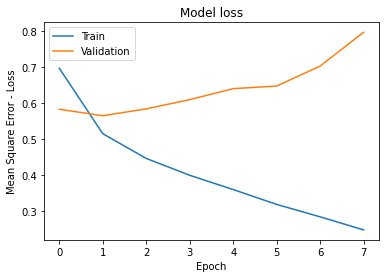

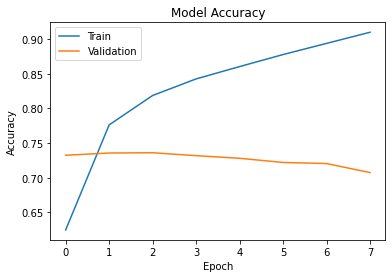

In [16]:
print('accuracy', model_emb.evaluate(X_test_pad,y_test)[1])
plot_loss(history_emb)

## build convolutional model

In [17]:
def generate_data_cnn(X_train,X_test):
    
    # YOUR CODE HERE
    X_train_pad = pad_sequences(X_train, dtype = 'float32',padding='post',maxlen=50)
    X__test_pad = pad_sequences(X_test, dtype = 'float32',padding='post',maxlen=50)
    
    return X_train_pad,X__test_pad

X_train_pad_cnn, X_test_pad_cnn = generate_data_cnn(sentences_token_train,sentences_token_test)

In [18]:
def init_model_cnn(vocab_size):
    
    model = Sequential()

    model.add(layers.Embedding(input_dim=vocab_size+1, output_dim=100,input_length=50, mask_zero=True))
    model.add(layers.Conv1D(16,kernel_size = 5, activation='relu')) 
    model.add(layers.Flatten()) 
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(3, activation='softmax'))

    model.compile(loss= 'categorical_crossentropy', 
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    return model

In [19]:
%%time
model_cnn = init_model_cnn(vocab_size)

es = EarlyStopping(patience=5,restore_best_weights=True,monitor='val_accuracy')
history_cnn = model_cnn.fit(X_train_pad_cnn, y_train,
          validation_split= 2/7,
          epochs=100, 
          batch_size=32, 
          verbose=1,
          use_multiprocessing=True,
          callbacks = [es])

Epoch 1/100
391/391 [==============================] - 15s 38ms/step - loss: 0.7004 - accuracy: 0.5846 - val_loss: 0.6001 - val_accuracy: 0.7116
Epoch 2/100
391/391 [==============================] - 13s 34ms/step - loss: 0.5247 - accuracy: 0.7673 - val_loss: 0.5894 - val_accuracy: 0.7244
Epoch 3/100
391/391 [==============================] - 12s 31ms/step - loss: 0.4250 - accuracy: 0.8284 - val_loss: 0.6074 - val_accuracy: 0.7284
Epoch 4/100
391/391 [==============================] - 13s 32ms/step - loss: 0.3328 - accuracy: 0.8754 - val_loss: 0.6724 - val_accuracy: 0.7110
Epoch 5/100
391/391 [==============================] - 14s 35ms/step - loss: 0.2463 - accuracy: 0.9137 - val_loss: 0.7494 - val_accuracy: 0.6926
Epoch 6/100
391/391 [==============================] - 13s 34ms/step - loss: 0.1833 - accuracy: 0.9370 - val_loss: 0.8403 - val_accuracy: 0.6862
Epoch 7/100
391/391 [==============================] - 12s 31ms/step - loss: 0.1422 - accuracy: 0.9526 - val_loss: 0.9649 - val_ac

235/235 [==============================] - 1s 3ms/step - loss: 0.6207 - accuracy: 0.7253
accuracy 0.7253333330154419


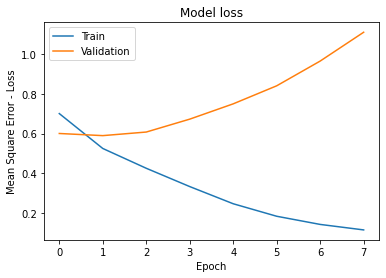

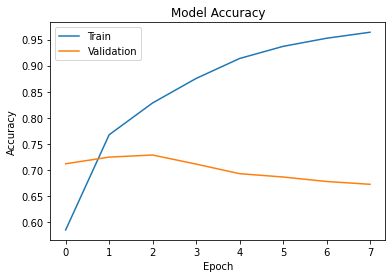

In [20]:
print('accuracy', model_cnn.evaluate(X_test_pad_cnn,y_test)[1])
plot_loss(history_cnn)

In [28]:
import pickle

filename = 'model_emb.sav'
pickle.dump(model_emb, open(filename, 'wb'))

# filename = 'model_cnn.sav'
# pickle.dump(model_cnn, open(filename, 'wb'))

# filename = 'model_w2v.sav'
# pickle.dump(model_w2v, open(filename, 'wb'))


TypeError: can't pickle _thread.RLock objects

In [27]:
import joblib

filename = 'model_emb.joblib'
joblib.dump(model_emb, filename)

# filename = 'model_cnn.joblib'
# pickle.dump(model_cnn, filename)

# filename = 'model_w2v.joblib'
# pickle.dump(model_w2v, filename)

TypeError: can't pickle _thread.RLock objects

## Evaluate

In [36]:
print('embeddings+LSTM accuracy:',model_emb.evaluate(X_test_pad,y_test))

235/235 [==============================] - ETA: 0s - loss: 0.5687 - accuracy: 0.73 - 3s 11ms/step - loss: 0.5699 - accuracy: 0.7353
embeddings+LSTM accuracy: [0.5698728561401367, 0.7353333234786987]


In [35]:
print('cnn accuracy:',model_cnn.evaluate(X_test_pad_cnn,y_test))

235/235 [==============================] - 2s 10ms/step - loss: 0.5795 - accuracy: 0.7255
cnn accuracy: [0.5794734954833984, 0.7254666686058044]


### Predict on London

In [29]:
import nest_asyncio
import sys
from green_mood_tracker.twint_class import TWINT
nest_asyncio.apply()

In [30]:
sys.path.insert(0, '../green_mood_tracker/')

In [31]:
kwargs = dict(
    keywords=['nuclear', 'green'],
    cities=['London', 'paris'],
    since = '2020-11-10 12:00:00',
    limit=200,
    file_path='../green_mood_tracker/data/london_nuclear.csv'
)

t = TWINT(**kwargs)

df_city = t.city_csv()

[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
Index(['id', 'conversation_id'], dtype='object')


In [32]:
! ls ../green_mood_tracker/data/

city.csv
data.csv.gz
general.csv
london_nuclear.csv


In [33]:
csv = pd.read_csv('../green_mood_tracker/data/london_nuclear.csv')

In [70]:
csv.head()
csv.shape

(85, 36)

In [68]:
csv.tweet.iloc[1]

'also dont lie say im green energy write youre totally subsidy nuclear wave energy odd'

In [54]:
X_new = clean(csv, 'tweet')['tweet']

In [65]:
X_new.head()

0    nuclear power pushed back burner uk’s green en...
1    also dont lie say im green energy write youre ...
2    nuclear power pushed back burner uk’s green en...
3    ce nuclear group support point plan amp £bn go...
4    nuclear power ‘green industrial revolution’ me...
Name: tweet, dtype: object

In [56]:
X_new_token = tk.texts_to_sequences(X_new)
X_new_token

[[737, 3127, 19, 637, 1872, 325],
 [201, 10, 1473, 65, 1, 637, 1872, 459, 76, 294, 1791, 1872, 2220],
 [737, 3127, 19, 637, 1872, 325],
 [10212,
  664,
  933,
  576,
  325,
  33,
  6796,
  6357,
  637,
  9329,
  2829,
  2697,
  1872,
  3071,
  1475,
  1670,
  3669,
  95,
  10935,
  805,
  33,
  5733,
  203],
 [737, 174, 95, 544, 1791],
 [737, 174, 95, 544, 1791],
 [9,
  1872,
  339,
  737,
  3127,
  19,
  637,
  1872,
  325,
  4623,
  4472,
  594,
  4503,
  1681,
  3217,
  4534,
  526,
  1872,
  1036],
 [2845,
  1456,
  11546,
  19413,
  2946,
  325,
  637,
  275,
  764,
  1872,
  5463,
  117,
  613,
  576,
  3210],
 [32, 99, 434, 19515, 1638, 637, 1872],
 [19565,
  1235,
  119,
  737,
  1153,
  13,
  33,
  3633,
  10651,
  737,
  4784,
  1206,
  10246,
  77,
  637,
  637],
 [77, 494, 639, 737, 1153, 749, 933, 14, 637, 121, 5, 1146, 1264, 134],
 [81, 3905, 121, 31, 2946, 637, 325],
 [81, 3905, 121, 31, 2946, 637, 325, 32, 580],
 [81, 3905, 121, 31, 2946, 637, 325],
 [764,
  14,
  1441,

In [57]:
X_new_pad = pad_sequences(X_new_token, dtype = 'float32',padding='post')

In [59]:
model_emb.predict(X_new_pad)

array([[5.25978804e-01, 4.43081418e-03, 4.69590396e-01],
       [2.12680832e-01, 8.00650194e-03, 7.79312670e-01],
       [5.25978804e-01, 4.43081418e-03, 4.69590396e-01],
       [3.92613202e-01, 6.25398196e-03, 6.01132810e-01],
       [7.20374405e-01, 6.63909037e-03, 2.72986472e-01],
       [7.20374405e-01, 6.63909037e-03, 2.72986472e-01],
       [4.14838672e-01, 5.15338685e-03, 5.80007970e-01],
       [9.06353071e-02, 7.58570945e-03, 9.01778996e-01],
       [3.85767907e-01, 6.75563375e-03, 6.07476473e-01],
       [1.57357961e-01, 2.32946360e-03, 8.40312600e-01],
       [2.54049122e-01, 8.53536092e-03, 7.37415493e-01],
       [2.30699494e-01, 3.43902223e-03, 7.65861511e-01],
       [2.19066441e-01, 2.54907273e-03, 7.78384447e-01],
       [2.30699494e-01, 3.43902223e-03, 7.65861511e-01],
       [8.69802117e-01, 5.66402683e-04, 1.29631415e-01],
       [1.87706053e-01, 1.07176192e-02, 8.01576257e-01],
       [1.86641306e-01, 2.44803610e-03, 8.10910642e-01],
       [5.25978804e-01, 4.43081